In [13]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
scv.settings.set_figure_params("scvelo")

In [3]:
# First of all, the input data for scVelo are two count matrices of pre-mature (unspliced) and mature (spliced) abundances, 
# which can be obtained from standard sequencing protocols, using the velocyto or kallisto counting pipeline.
adata = sc.read(
    filename = 'endocrinogenesis_day15.h5ad',
    # backup_url = 'https://github.com/theislab/scvelo_notebooks/raw/master/data/Pancreas/endocrinogenesis_day15.h5ad',
)


In [4]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Data preprocessing

In [5]:
# filter out genes that are not sufficiently expressed both unspliced and spliced RNA
# identify and filter for highly variable genes
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [6]:
# In the case of RNA velocity, we additionally smooth observations by the mean expression in their neighborhood
sc.tl.pca(adata)
sc.pp.neighbors(adata)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


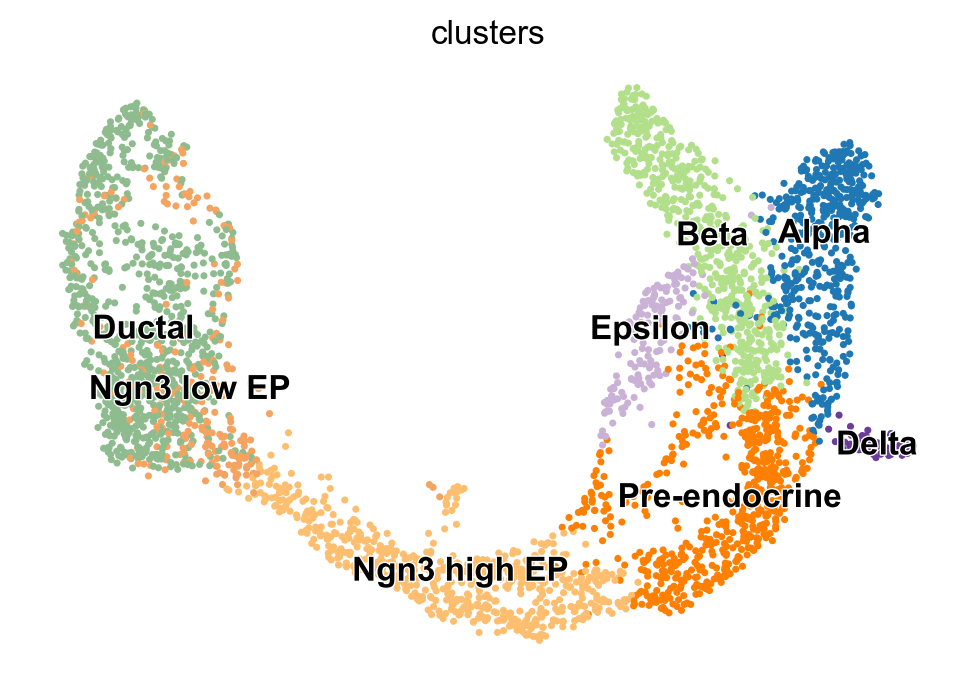

In [17]:
scv.pl.scatter(adata, basis="umap", color="clusters")

# RNA velocity inference - Steady-state model

In [7]:
scv.tl.velocity(adata, mode="deterministic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


computing velocity graph (using 16/112 cores)
or disable the progress bar using `show_progress_bar=False`.


    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


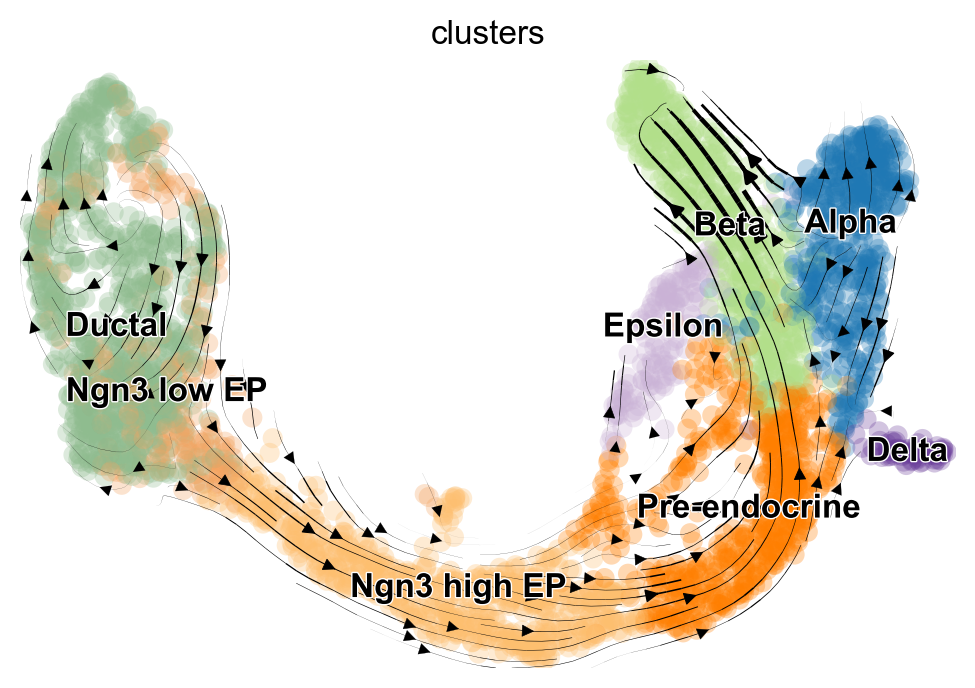

In [8]:
scv.tl.velocity_graph(adata, n_jobs=16)
scv.pl.velocity_embedding_stream(adata, basis="umap", color="clusters")

# RNA velocity inference - EM model

In [15]:
# In order to calculate RNA velocity with the EM model, the parameters of splicing kinetics need to be infered first.
scv.tl.recover_dynamics(adata, n_jobs=16)

recovering dynamics (using 8/112 cores)
    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [18]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index
# scv.pl.scatter(adata, basis=top_genes[:5], color="clusters", frameon=False)

In [19]:
top_genes

Index(['Pcsk2', 'Ghrl', 'Top2a', 'Nfib', 'Ppp1r1a', 'Pak3', 'Ank', 'Shank2',
       'Adk', 'Bicc1',
       ...
       'Rnf128', 'Prps1', 'Fgd1', 'Hsd17b10', '2210013O21Rik', 'Map7d2',
       'Rbbp7', 'Uty', 'Ddx3y', 'Erdr1'],
      dtype='object', name='index', length=2000)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 16/112 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


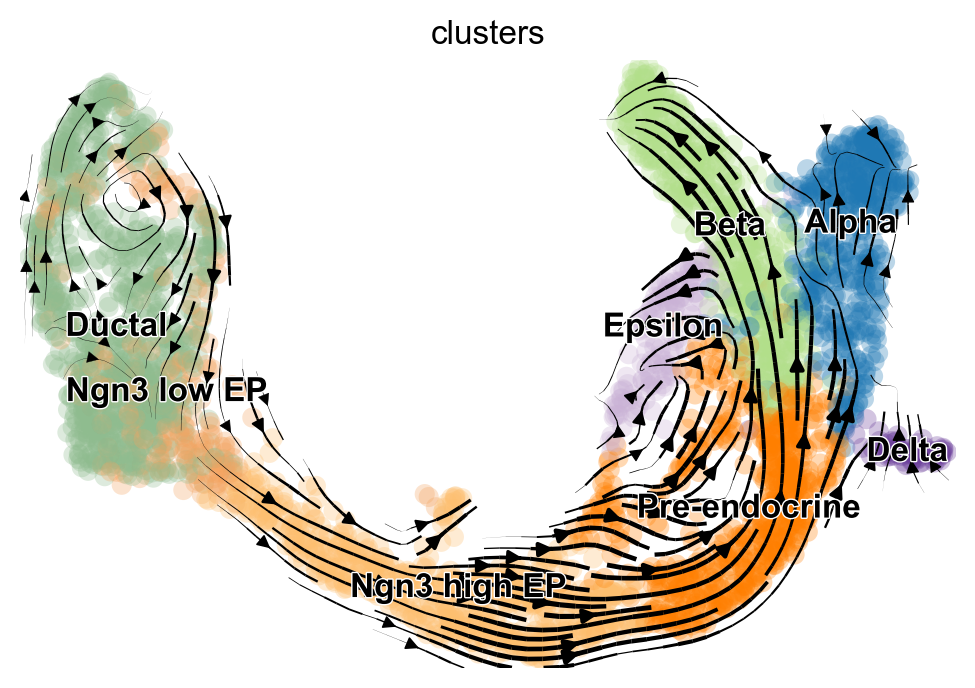

In [20]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata, n_jobs=16)
scv.pl.velocity_embedding_stream(adata, basis="umap")

In [22]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'recover_dynamics'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity_u'
    obsp: 'distances', '

However, for a rigorous and quantitative analysis, we recommend using downstream tools such as CellRank [Lange et al., 2022] to assess model differences and draw conclusions.

In [11]:
import session_info

In [14]:
session_info.show()